## Motivation

We want to know how a house buyer describes their dream house. Do they start with describing the neighborhood, the number of rooms, the number of cars in the garage, etc?! What are their preferences?!
We also want to develop a model to predict the house prices based on the available preferences.

We will use a dataset of homes in Ames, Iowa to explores 79 variables and to build a prediction model using the train dataset. Then, the model will be used to predict the house prices in the test dataset.

#### Reference

The Ames Housing dataset was compiled by Dean De Cock for use in data science education.

## Import Needed Modules

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import sklearn.ensemble
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
plt.style.use('ggplot')

## Data Exploration
Handling Missing Data

In [2]:
train=pd.read_csv('train.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(train.shape)


(1460, 81)


Comibine Features

In [5]:
X=train.drop(['SalePrice'],axis=1)
X.reset_index(drop=True,inplace=True)
print(X.shape)
X.head()

(1460, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Find columns with the most missing data with respect to the size of the test data.

Text(0, 0.5, 'Missingness %')

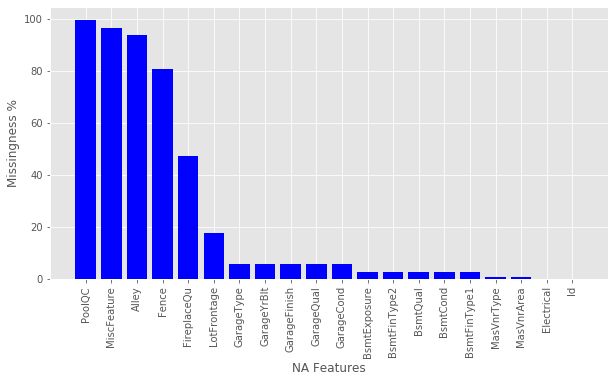

In [6]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:20])
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

- 99.5% of **PoolQC** is missing
- 96.3% of **MiscFeature** is missing
- 93.7% of **Alley** is missing
- 80.7% of **Fence** is missing
- 47.2% of **FireplaceQu** is missing

These data are missing because some features do not exist in some houses. So, the actual values will be imputed as they are referenced in the data description file.

In [7]:
X['PoolQC'].fillna('No Pool',inplace=True)
X['MiscFeature'].fillna('None',inplace=True)
X['Alley'].fillna('No alley access',inplace=True)
X['Fence'].fillna('No Fence',inplace=True)
X['FireplaceQu'].fillna('No Fireplace',inplace=True)

X['GarageType'].fillna('No Garage',inplace=True)
X['GarageFinish'].fillna('No Garage',inplace=True)
X['GarageQual'].fillna('No Garage',inplace=True)

X['BsmtExposure'].fillna('No Basement',inplace=True)
X['BsmtFinType1'].fillna('No Basement',inplace=True)
X['BsmtFinType2'].fillna('No Basement',inplace=True)
X['BsmtQual'].fillna('No Basement',inplace=True)
X['BsmtCond'].fillna('No Basement',inplace=True)
X['GarageCond'].fillna('No Garage',inplace=True)

Since, the year in which the garage was built has about 5% missing data, and we cannot assume that the year is zero if there is not a garage, we will try to get rid of the column but after checking the correlation with the year in which the house is built.
The year the garage is built and the year the house is built are highly correlated. therefore, he year the garage is built will be removed from the data. And, another parameter for Garage will be added (1= there's a garage, 0=No garage).

[[1.         0.82566748]
 [0.82566748 1.        ]]


Text(0, 0.5, 'Year House Built')

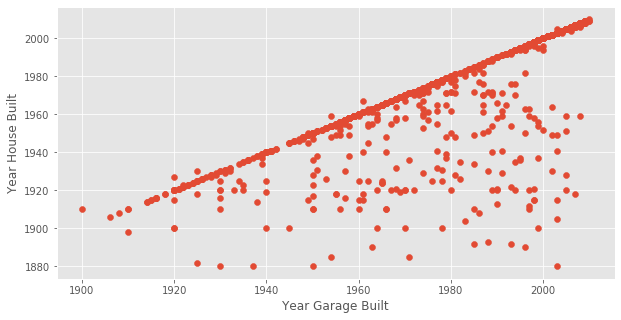

In [8]:
garage_year=pd.DataFrame({'GarageYrBlt':X['GarageYrBlt'],'YearBuilt':X['YearBuilt']})
garage_year.dropna(inplace=True)
garage_year
plt.scatter(garage_year['GarageYrBlt'],garage_year['YearBuilt'])
print(np.corrcoef(garage_year['GarageYrBlt'],garage_year['YearBuilt']))
plt.xlabel('Year Garage Built')
plt.ylabel('Year House Built')

In [9]:
X.drop('GarageYrBlt',axis=1,inplace=True)
X['Garage']=X['GarageType'].apply(lambda x: 0 if x=='No Garage' else 1)

Text(0, 0.5, 'Missingness %')

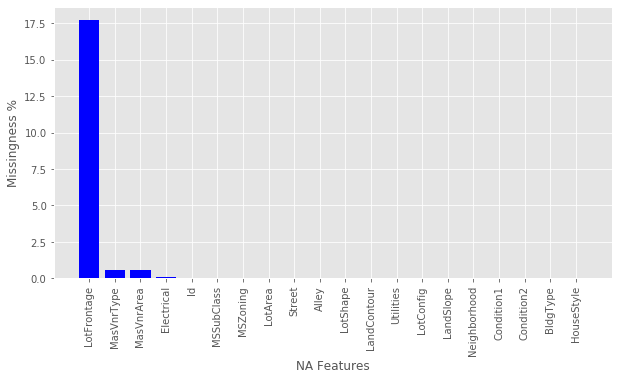

In [10]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:20])
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

After imputing the true values of NA in the features set, we still have 18% of the data missing.

In [11]:
(X.shape[0]-X.dropna().shape[0])/X.shape[0]

0.1821917808219178

The missing percentage in MasVnrType and MasVnrArea are almost the same. We will see if there's a correlation between them.

Text(0, 0.5, 'Missingness %')

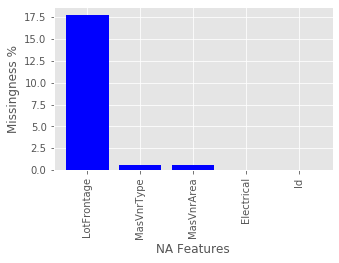

In [12]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:5])
plt.rcParams['figure.figsize'] = (5,3)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

Check the correlation between missing data using a heat map.
- Missing data are almost the same in MasVnrArea and MasVnrType

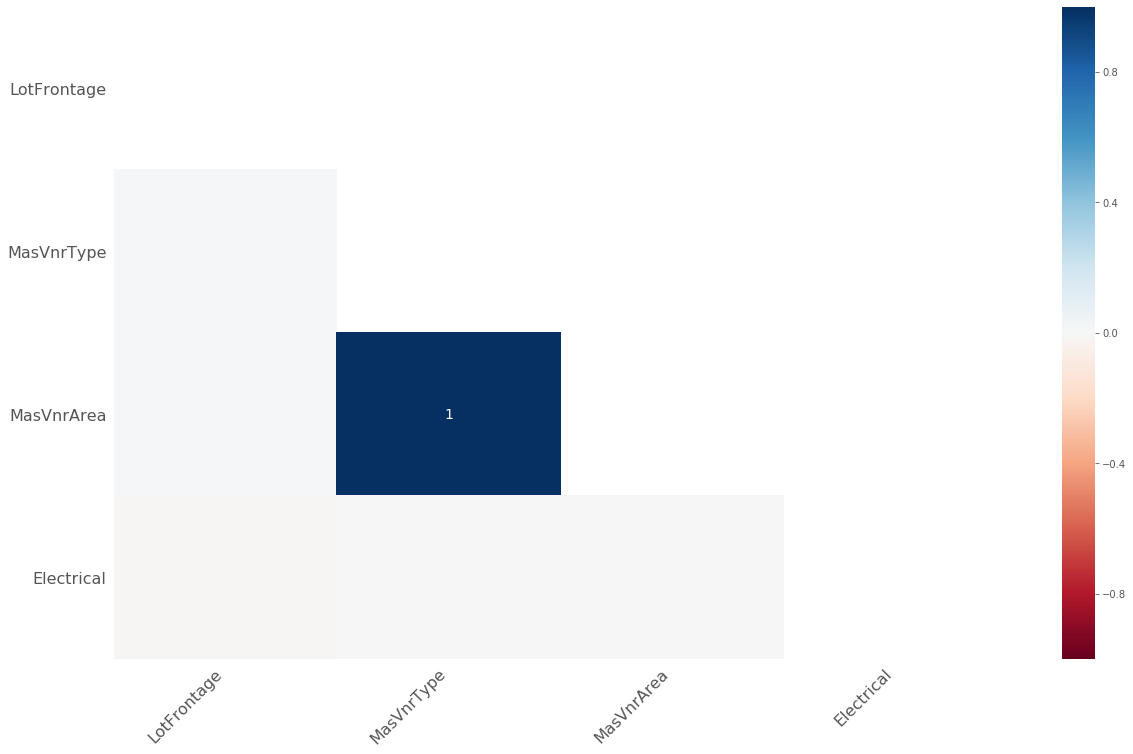

In [13]:
msno.heatmap(X)

MasVnrArea is mostly NaN when when MasVnrType is missing. MasVnrType will be imputed as "None" and "MasVnrArea"will be imputed as "0".

In [14]:
X['MasVnrArea'].loc[X['MasVnrType'].isna()]

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

In [15]:
X['MasVnrType'].loc[X['MasVnrType'].isna()]

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

For these missing observations. MasVnrType will be imputed as "None" and "MasVnrArea"will be imputed as "0".

In [16]:
X['MasVnrType'].fillna('None',inplace=True)
X['MasVnrArea'].fillna(0,inplace=True)

Now, we have 17.5% of the data missing in LotFrontage. There's only one missing value in Electrical, and we will drop it.

We will use KNN neighbor to impute the missing values.

Text(0, 0.5, 'Missingness %')

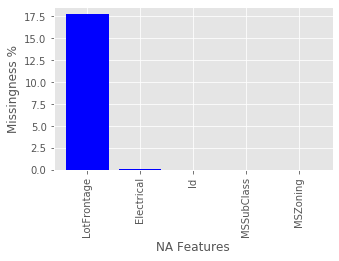

In [17]:
NaNcols=X.isna().sum()/X.shape[0]*100
a,b=zip(*sorted(zip(NaNcols.index,NaNcols),key=lambda t:t[1],reverse=True)[:5])
plt.rcParams['figure.figsize'] = (5,3)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('NA Features')
plt.ylabel('Missingness %')

Drop the observation with NA in Electrical

In [18]:
X.dropna(subset=['Electrical'],inplace=True)

In order to use Gower distance and for decision tree purposes, we need to start encoding ordinal features because Gower can handle categorical features as they are.

Split categorical and ordinal features.

In [19]:
string_features=X.select_dtypes('object').columns
ordered_features=np.array(['LotShape','LandSlope','ExterQual', 'ExterCond',
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                 'HeatingQC','KitchenQual','Functional', 'FireplaceQu',
                 'GarageFinish', 'GarageQual', 'GarageCond',
                 'PoolQC','Fence'])
categ_features=np.array(['MSZoning','Street','Alley','LandContour',
               'Utilities','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                'Exterior2nd', 'MasVnrType','Foundation','Heating',
               'CentralAir', 'Electrical','GarageType','PavedDrive',
               'MiscFeature','SaleType','SaleCondition'])
# Keep the Id and SalePrice columns from the numerical features.
numerical_features=X.select_dtypes('number').columns
print(string_features.shape)
print(ordered_features.shape)
print(categ_features.shape)
print(numerical_features.shape)
print(X.shape)
#np.setdiff1d(string_features,np.union1d(ordered_features,categ_features))

(43,)
(18,)
(25,)
(37,)
(1459, 80)


In [20]:
numerical_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Garage'],
      dtype='object')

Check the unique values in the categ_features.

In [21]:
for name in categ_features:
    print(name,X[name].unique())

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street ['Pave' 'Grvl']
Alley ['No alley access' 'Grvl' 'Pave']
LandContour ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities ['AllPub' 'NoSeWa']
LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'


Get unique values of the ordinal data to encode them.

In [22]:
for name in ordered_features:
    print(name,X[name].unique())

LotShape ['Reg' 'IR1' 'IR2' 'IR3']
LandSlope ['Gtl' 'Mod' 'Sev']
ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'No Basement' 'Fa']
BsmtCond ['TA' 'Gd' 'No Basement' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'No Basement']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'No Basement' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'No Basement' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
FireplaceQu ['No Fireplace' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'No Garage']
GarageQual ['TA' 'Fa' 'Gd' 'No Garage' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'No Garage' 'Gd' 'Po' 'Ex']
PoolQC ['No Pool' 'Ex' 'Fa' 'Gd']
Fence ['No Fence' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


Create a dictionary to map the ordinal features based on the natural order.

In [23]:
ordinal_feature_mapping=[{
    "col": "LotShape",
    "mapping": {
        'Reg': 0,
        'IR1': 1,
        'IR2': 2,
        'IR3': 3
    }}, {
    "col": "LandSlope",
    "mapping": {
        'Gtl': 0,
        'Mod': 1,
        'Sev': 2
    }}, {
    "col": "ExterQual",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "ExterCond",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "BsmtQual",
    "mapping": {
        'No Basement': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "BsmtCond",
    "mapping": {
        'No Basement': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "BsmtExposure",
    "mapping": {
        'No Basement': 0,
        'No': 1,
        'Mn': 2,
        'Av': 3,
        'Gd': 4
    }}, {
    "col": "BsmtFinType1",
    "mapping": {
        'No Basement': 0,
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6
    }}, {
    "col": "BsmtFinType2",
    "mapping": {
        'No Basement': 0,
        'Unf': 1,
        'LwQ': 2,
        'Rec': 3,
        'BLQ': 4,
        'ALQ': 5,
        'GLQ': 6   
    }}, {
    "col": "HeatingQC",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }},{
    "col": "KitchenQual",
    "mapping": {
        'Po': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "Functional",
    "mapping": {
        'Sal': 0,
        'Sev': 1,
        'Maj2': 2,
        'Maj1': 3,
        'Mod': 4,
        'Min2': 5,
        'Min1': 6,
        'Typ': 7
    }}, {
    "col": "FireplaceQu",
    "mapping": {
        'No Fireplace': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "GarageFinish",
    "mapping": {
        'No Garage': 0,
        'Unf': 1,
        'RFn': 2,
        'Fin': 3
    }}, {
    "col": "GarageQual",
    "mapping": {
        'No Garage': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "GarageCond",
    "mapping": {
        'No Garage': 0,
        'Po': 1,
        'Fa': 2,
        'TA': 3,
        'Gd': 4,
        'Ex': 5
    }}, {
    "col": "PoolQC",
    "mapping": {
        'No Pool': 0,
        'Fa': 1,
        'TA': 2,
        'Gd': 3,
        'Ex': 4
    }}, {
    "col": "Fence",
    "mapping": {
        'No Fence': 0,
        'MnWw': 1,
        'GdWo': 2,
        'MnPrv': 3,
        'GdPrv': 4
    }}
]

Use the encoding dictionary to convert the ordinal features into ordered numerical values.

In [24]:
ord_encoder= ce.OrdinalEncoder(mapping = ordinal_feature_mapping, 
                             return_df = True)

In [25]:
ordered_data=ord_encoder.fit_transform(X[ordered_features])
for name in ordered_features:
    print(name,ordered_data[name].unique())
print(ordered_data.shape)

LotShape [0 1 2 3]
LandSlope [0 1 2]
ExterQual [3 2 4 1]
ExterCond [2 3 1 0 4]
BsmtQual [4 3 5 0 2]
BsmtCond [3 4 0 2 1]
BsmtExposure [1 4 2 3 0]
BsmtFinType1 [6 5 1 3 4 0 2]
BsmtFinType2 [1 4 0 5 3 2 6]
HeatingQC [4 3 2 1 0]
KitchenQual [3 2 4 1]
Functional [7 6 3 5 4 2 1]
FireplaceQu [0 3 4 2 5 1]
GarageFinish [2 1 3 0]
GarageQual [3 2 4 0 5 1]
GarageCond [3 2 0 4 1 5]
PoolQC [0 4 1 3]
Fence [0 3 2 4 1]
(1459, 18)


We create a data set that will be used to impute mising LotFrontage area. The data is consisted of the ordinal, categorical and numerical features except 'Id'.

In [26]:
imputation_data=pd.concat([ordered_data,X[categ_features],X[numerical_features]],axis=1)

We will try imputation of **LotFrontage** in **R** using KNN and Gower's distance.

In [27]:
imputation_data.to_csv('imputation_train_set.csv')

When the method is tested on data that existed in X data set. The mean absolute error was about 11.7 feet (16.8% of the mean Lot Frontage).
The percentate of missing data is now 0 %.

In [28]:
imp=pd.read_csv('imputed_train_data.csv')
(imp.shape[0]-imp.dropna().shape[0])/imp.shape[0]*100

0.0

Some Feature names changed in R because they start with a number. Get the feature names that changes

In [29]:
np.setdiff1d(imp.columns,imputation_data.columns)

array(['LotFrontage_imp', 'X1stFlrSF', 'X2ndFlrSF', 'X3SsnPorch'],
      dtype=object)

In [30]:
imp.drop('LotFrontage_imp',axis=1,inplace=True)
imp.rename(columns={'X1stFlrSF':'1stFlrSF','X2ndFlrSF':'2ndFlrSF','X3SsnPorch':'3SsnPorch'},inplace=True)

In [31]:
np.setdiff1d(imp.columns,imputation_data.columns)

array([], dtype=object)

In [32]:
np.setdiff1d(imputation_data.columns,imp.columns)

array([], dtype=object)

Combine numerical and ordinal data in xdata

In [33]:
xdata=pd.DataFrame()
for name in ordered_features:
    xdata[name]=np.array(imp[name])
for name in numerical_features:
    xdata[name]=np.array(imp[name])
xdata.shape

(1459, 55)

## Examining Correlations between Features (Numerical and Ordinal)

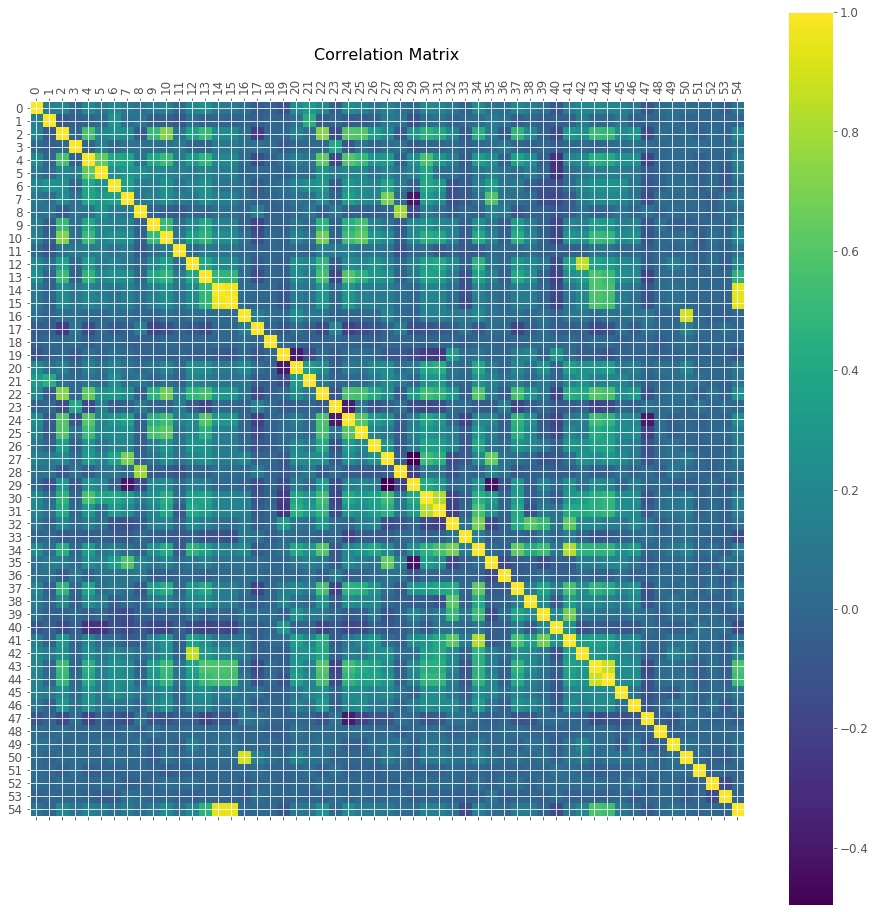

In [34]:
corr=xdata.corr()
#corr[corr>0.8]
plt.rcParams['figure.figsize'] = (20,20)
plt.matshow(corr)
plt.xticks(range(corr.shape[0]),fontsize=12, rotation=90)
plt.yticks(range(corr.shape[0]),fontsize=12)
plt.colorbar().ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=16);


'GarageQual' and 'GarageCond' are highly correlated and they have the same correlation with the rest of the features. One of them will be enough.

In [35]:
corr.columns[[14,15]]

Index(['GarageQual', 'GarageCond'], dtype='object')

'TotalBsmtSF' and '1stFlrSF' are highly correlated and they have almost the same correlation with the rest of the features. One of them will be enough.

In [36]:
corr.columns[[29,30]]

Index(['BsmtUnfSF', 'TotalBsmtSF'], dtype='object')

'GarageCars'and 'GarageArea' are highly correlated and they have almost the same correlation with the rest of the features. One of them will be enough.

In [37]:
corr.columns[[42,43]]

Index(['Fireplaces', 'GarageCars'], dtype='object')

Drop 'GarageCond', '1stFlrSF' and 'GarageArea'.

In [38]:
xdata.drop(['GarageCond', '1stFlrSF','GarageArea'],axis=1,inplace=True)
xdata.shape

(1459, 52)

## Prepare Data For Modeling

Create a data frame for Y with the SalePrice but exclude the ID that will dropped during the data exploration process.

In [39]:
np.setdiff1d(train['Id'],X['Id'])

array([1380], dtype=int64)

In [40]:
Yt=train[train['Id'] != 1380]['SalePrice']
Yt.reset_index(drop=True,inplace=True)
xdata.reset_index(drop=True,inplace=True)

Check Data Integrity

In [41]:
Yt.tail()

1454    175000
1455    210000
1456    266500
1457    142125
1458    147500
Name: SalePrice, dtype: int64

In [42]:
train['SalePrice'].tail()

1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, dtype: int64

Dummify The rest of the categorial features.

In [43]:
categ_data=pd.get_dummies(imp[categ_features],prefix=categ_features,drop_first=True)

In [44]:
categ_data.shape

(1459, 149)

Combine Categorical, Ordinal and Numeric Features in xdata.

In [45]:
xdata=pd.concat([categ_data,xdata],axis=1)
xdata.shape

(1459, 201)

Split tdata into training and test sets. Feature data Xt deosn't include 'Id'. Target data Y is the 'SalePrice'.

In [46]:
Xt=xdata.drop(['Id'],axis=1)
np.random.seed(0)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Xt,Yt, test_size=0.3)

## Use Gradient Boosting Regression Trees to model the data.

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
np.random.seed(0)
gbm= GradientBoostingRegressor()
gbm.fit(X_train,Y_train)
print('Training Score= ',gbm.score(X_train,Y_train))
print('Test Score= ',gbm.score(X_test,Y_test))
y_pred_train=gbm.predict(X_train)
y_pred_test=gbm.predict(X_test)
print('Training MSE= ',gbm.loss_(Y_train,y_pred_train))
print('Test MSE= ',gbm.loss_(Y_test,y_pred_test))
mape_test=np.mean(np.abs((Y_test - y_pred_test) / Y_test)) * 100
mape_train=np.mean(np.abs((Y_train - y_pred_train) / Y_train)) * 100
print('Train Mape= ',mape_train)
print('Test Mape= ',mape_test)

Training Score=  0.9736982702606071
Test Score=  0.8827987386477998
Training MSE=  174645427.91688263
Test MSE=  648601705.1625524
Train Mape=  6.2108250248206405
Test Mape=  9.496300513006982


There's a big gap between test and train R2. So, we will try to vary the n_estimators

### Varying GBM Parameters

In [49]:
from sklearn.metrics import r2_score

In [50]:
np.random.seed(0)
steps=5100
gbm.set_params(n_estimators=steps,learning_rate=0.005,verbose=False)
gbm.fit(X_train,Y_train)
gen_train=gbm.staged_predict(X_train)
gen_test=gbm.staged_predict(X_test)
r2s_train=[]
r2s_test=[]
mse_train=[]
mse_test=[]
mape_train=[]
mape_test=[]
recording_steps=range(100,steps,100)
for i in range(steps):
    staged_Y_train=next(gen_train)
    staged_Y_test=next(gen_test)
    if i not in recording_steps:continue
    r2s_train.append(r2_score(Y_train,staged_Y_train))
    r2s_test.append(r2_score(Y_test,staged_Y_test))
    mse_train.append(gbm.loss_(Y_train,staged_Y_train))
    mse_test.append(gbm.loss_(Y_test,staged_Y_test))
    mape_train.append(np.mean(np.abs((Y_train - staged_Y_train) / Y_train)) * 100)
    mape_test.append(np.mean(np.abs((Y_test - staged_Y_test) / Y_test)) * 100)

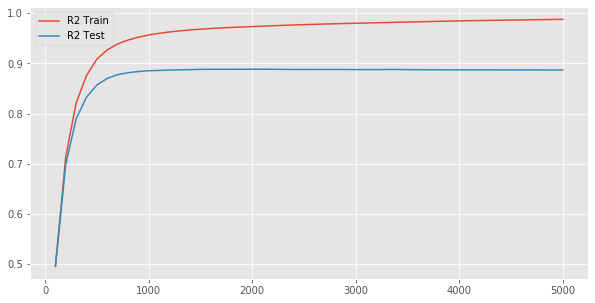

In [51]:
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(recording_steps,r2s_train,label='R2 Train')
plt.plot(recording_steps,r2s_test,label='R2 Test')
plt.legend()

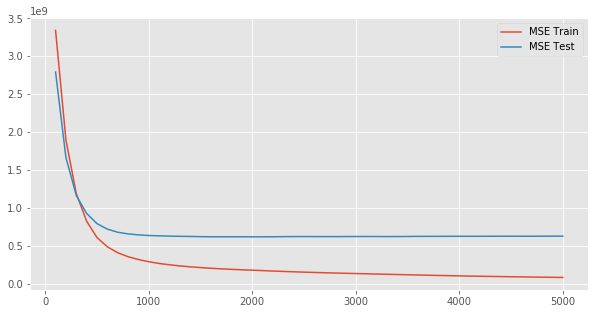

In [52]:
plt.plot(recording_steps,mse_train,label='MSE Train')
plt.plot(recording_steps,mse_test,label='MSE Test')
plt.legend()

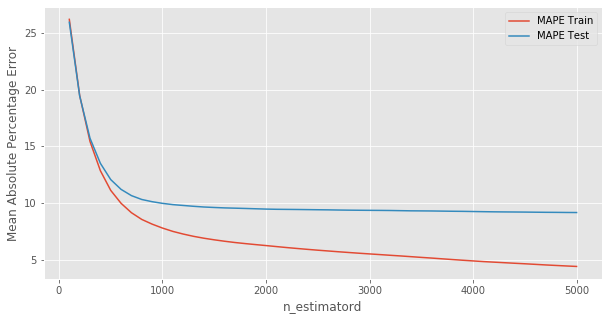

In [53]:
plt.plot(recording_steps,mape_train,label='MAPE Train')
plt.plot(recording_steps,mape_test,label='MAPE Test')
plt.xlabel('n_estimatord')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()

## Cross-validation

In [54]:
np.random.seed(0)
grid_para_gbm = [{
    "n_estimators": [1000],
    "max_depth": [2,3,5,10],
    "max_features": [5,10,15,20,25]
}]
grid_search_gbm = GridSearchCV(gbm, grid_para_gbm, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
%time grid_search_gbm.fit(X_train, Y_train)

Wall time: 22.2 s


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(learning_rate=0.005,
                                                 n_estimators=5100,
                                                 verbose=False),
             n_jobs=-1,
             param_grid=[{'max_depth': [2, 3, 5, 10],
                          'max_features': [5, 10, 15, 20, 25],
                          'n_estimators': [1000]}],
             scoring='neg_mean_absolute_error')

In [55]:
grid_search_gbm.best_params_

{'max_depth': 5, 'max_features': 25, 'n_estimators': 1000}

In [56]:
grid_search_gbm.best_score_

-15932.762728421882

Use the CV parameters to fit a model

In [57]:
np.random.seed(0)
steps=5100
gbm.set_params(n_estimators=steps,verbose=False,max_depth=5,max_features=25)
gbm.fit(X_train,Y_train)
gen_train=gbm.staged_predict(X_train)
gen_test=gbm.staged_predict(X_test)
r2s_train=[]
r2s_test=[]
mse_train=[]
mse_test=[]
mape_train=[]
mape_test=[]
recording_steps=range(100,steps,100)
for i in range(steps):
    staged_Y_train=next(gen_train)
    staged_Y_test=next(gen_test)
    if i not in recording_steps:continue
    r2s_train.append(r2_score(Y_train,staged_Y_train))
    r2s_test.append(r2_score(Y_test,staged_Y_test))
    mse_train.append(gbm.loss_(Y_train,staged_Y_train))
    mse_test.append(gbm.loss_(Y_test,staged_Y_test))
    mape_train.append(np.mean(np.abs((Y_train - staged_Y_train) / Y_train)) * 100)
    mape_test.append(np.mean(np.abs((Y_test - staged_Y_test) / Y_test)) * 100)

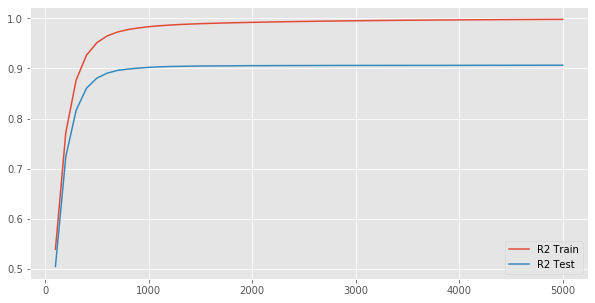

In [58]:
plt.plot(recording_steps,r2s_train,label='R2 Train')
plt.plot(recording_steps,r2s_test,label='R2 Test')
plt.legend()

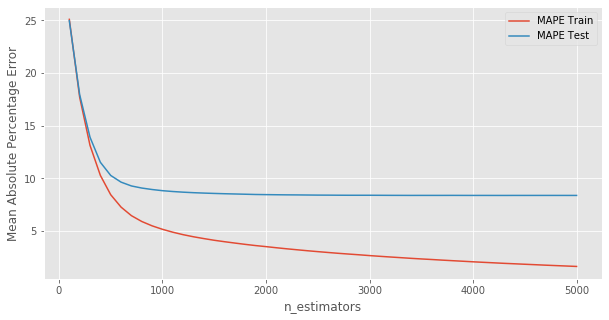

In [59]:
plt.plot(recording_steps,mape_train,label='MAPE Train')
plt.plot(recording_steps,mape_test,label='MAPE Test')
plt.xlabel('n_estimators')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()

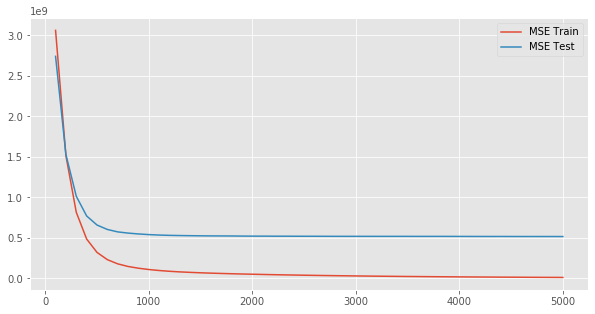

In [60]:
plt.plot(recording_steps,mse_train,label='MSE Train')
plt.plot(recording_steps,mse_test,label='MSE Test')
plt.legend()

Test perfoemance stabilices at 1000 trees but there is over-fitting. We will do feature importance analysis at different number of trees to investigate each feature.

In [61]:
np.random.seed(0)
gbm.set_params(n_estimators=1000,warm_start=False)
gbm.fit(X_train,Y_train)
y_train_predict=gbm.predict(X_train)
y_test_predict=gbm.predict(X_test)
print('MAPE train= ',np.mean(np.abs((Y_train - y_train_predict) / Y_train)) * 100,'%')
print('MAPE test= ',np.mean(np.abs((Y_test - y_test_predict) / Y_test)) * 100,'%')
print('R2 train',r2_score(Y_train,y_train_predict))
print('R2 test',r2_score(Y_test,y_test_predict))

MAPE train=  5.16198649677194 %
MAPE test=  8.826772747682782 %
R2 train 0.9834210331634489
R2 test 0.9021868609126217


Study how feature importance change with changing number of trees.

In [62]:
from copy import deepcopy

gbm_models   = []
warm_start   = False
steps        = list(range(100,2100,100))
np.random.seed(0)
for n_estimators in steps:
                gbm.set_params(n_estimators=n_estimators, warm_start=warm_start)
                gbm_models.append(deepcopy(gbm.fit(X_train, Y_train))) 
                warm_start = True

In [63]:
feature_importance = pd.DataFrame([model.feature_importances_ for model in gbm_models], index=steps, columns=X_train.columns)
feature_importance.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_No alley access,Alley_Pave,LandContour_HLS,LandContour_Low,LandContour_Lvl,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Garage
100,0.000009,0.0,0.000835,0.001825,0.000023,0.000022,0.000079,0.000011,0.000225,0.000598,...,0.001562,0.006506,0.000393,0.000000,0.000684,0.000347,0.000000,0.001058,0.000561,0.000379
200,0.000009,0.0,0.000954,0.001935,0.000016,0.000022,0.000065,0.000031,0.000188,0.000900,...,0.001444,0.006348,0.000311,0.000000,0.000700,0.000703,0.000010,0.001446,0.000515,0.000544
300,0.000010,0.0,0.001032,0.002006,0.000019,0.000030,0.000074,0.000080,0.000206,0.000973,...,0.001730,0.007322,0.000300,0.000005,0.000773,0.000778,0.000011,0.001634,0.000499,0.000538
400,0.000019,0.0,0.001160,0.002111,0.000018,0.000029,0.000077,0.000222,0.000252,0.001131,...,0.001986,0.007511,0.000303,0.000004,0.000921,0.000787,0.000013,0.001741,0.000513,0.000548
500,0.000060,0.0,0.001236,0.002118,0.000018,0.000031,0.000088,0.000250,0.000264,0.001174,...,0.002175,0.007832,0.000327,0.000004,0.001033,0.000801,0.000014,0.001864,0.000552,0.000545


Text(0, 0.5, 'feature importance')

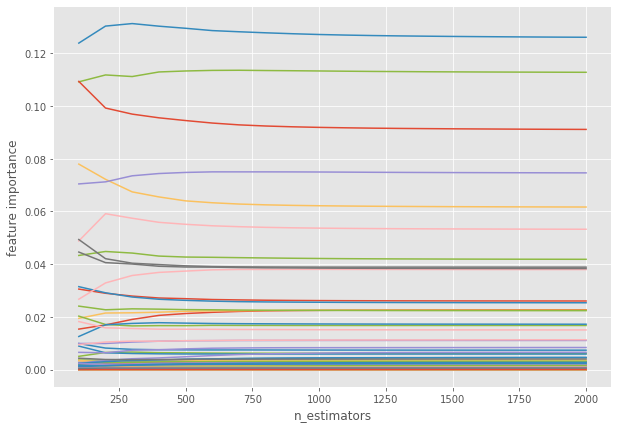

In [64]:
plt.rcParams['figure.figsize'] = (10,7)
for feature in feature_importance.columns:
    plt.plot(feature_importance.index, feature_importance[feature], label=feature)
plt.xlabel('n_estimators')
plt.ylabel('feature importance')

The features seem to stabilize after 1000 trees. So we will get the feature importance at that point.

In [65]:
np.random.seed(0)
gbm.set_params(n_estimators=1000,warm_start=False)
gbm.fit(X_train,Y_train)
sorted_importance = sorted(zip(X_train.columns, gbm.feature_importances_), key=lambda t:t[1], reverse=True)

Get the top 50 features

In [66]:
top50_features=sorted_importance[:50]

Text(0, 0.5, 'Importance')

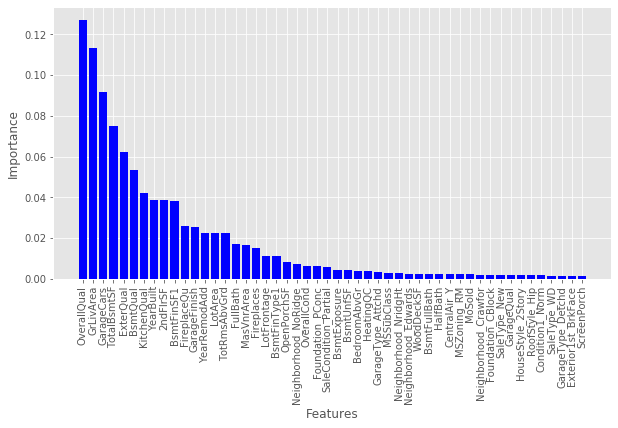

In [67]:
plt.rcParams['figure.figsize'] = (10,5)
a,b=zip(*top50_features)
plt.bar(a,b,color='b')
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')

Change the model features to only the top 50 features.

In [68]:
Xs_train=X_train.loc[:,np.array(a)]
Xs_test=X_test.loc[:,np.array(a)]

MAPE has decreased for the train set but increased for the test set. Which means that there's more error here that is possibly caused by underfitting on the test set.

In [69]:
np.random.seed(0)
gbm.fit(Xs_train,Y_train)
y_train_predict=gbm.predict(Xs_train)
y_test_predict=gbm.predict(Xs_test)
print('MAPE train= ',np.mean(np.abs((Y_train - y_train_predict) / Y_train)) * 100,'%')
print('MAPE test= ',np.mean(np.abs((Y_test - y_test_predict) / Y_test)) * 100,'%')
print('Training Score= ',gbm.score(Xs_train,Y_train))
print('Test Score= ',gbm.score(Xs_test,Y_test))

MAPE train=  4.61610027992111 %
MAPE test=  8.975174245976572 %
Training Score=  0.9871260701712181
Test Score=  0.8995201721185437


The most important feature is the rate of the overall material and finish of the house. From the plot, it's cear that the Sale price increases with the overall quality.

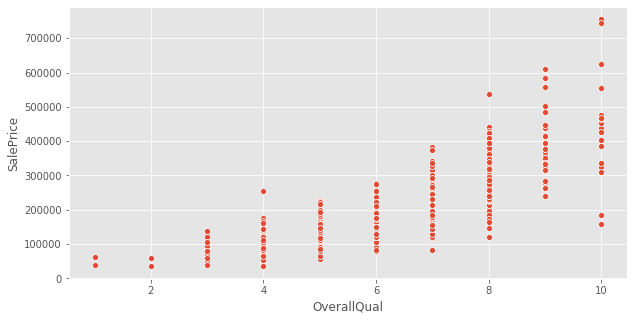

In [70]:
sns.scatterplot(data=xdata,x=xdata['OverallQual'],y=Yt)

For the most important features 'OverallQual' and 'GrLivArea', it is clear that as they increase, the sale price increases. 

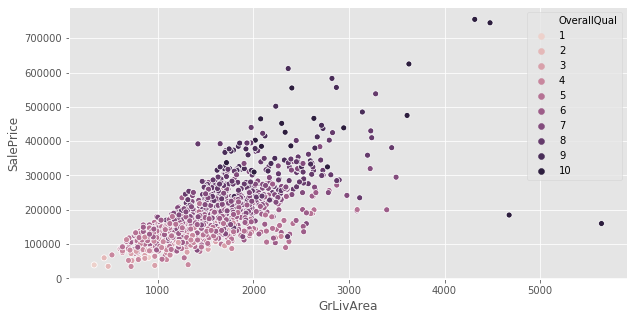

In [71]:
sns.scatterplot(data=xdata,x=xdata['GrLivArea'],y=Yt,hue=xdata['OverallQual'],legend="full")

The number of cars in the garage comes in the 3rd place. As the number of cars increase the quality and the price increase

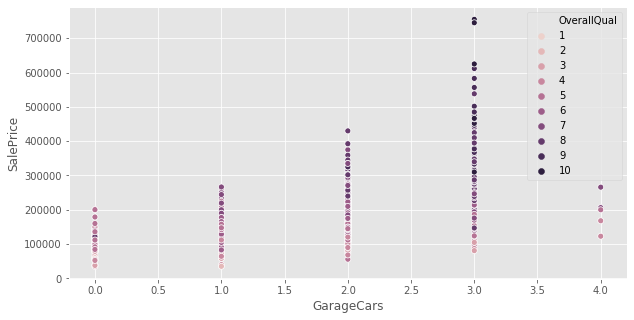

In [72]:
sns.scatterplot(data=xdata,x=xdata['GarageCars'],y=Yt,hue=xdata['OverallQual'],legend="full")

Basment square footage comes 4th and the the quality and price increase with it.

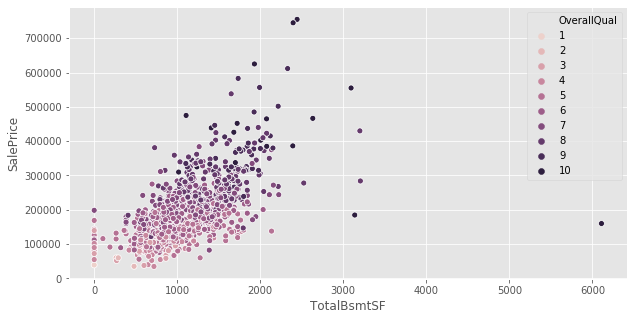

In [73]:
sns.scatterplot(data=xdata,x=xdata['TotalBsmtSF'],y=Yt,hue=xdata['OverallQual'],legend="full")

The quality of the material on the exterior comes 5th and it increases the quality and the price.

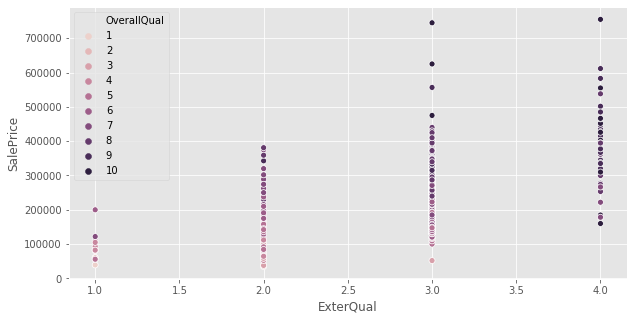

In [74]:
sns.scatterplot(data=xdata,x=xdata['ExterQual'],y=Yt,hue=xdata['OverallQual'],legend="full")

It is interesting to look at how the year when the house is built affects the price. It looks like the year does not have a huge influence before 1980 but it increases after then and so does the quality of the house.

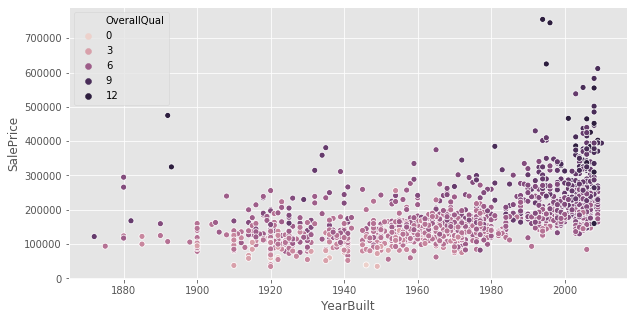

In [75]:
sns.scatterplot(data=xdata,x=xdata['YearBuilt'],y=Yt,hue=xdata['OverallQual'])

It is also interesting to look how the overall condition of the house affects the price. There is not a significant effect on the prices. However, houses with average condition have the highest material and finish quality rates and prices as well.

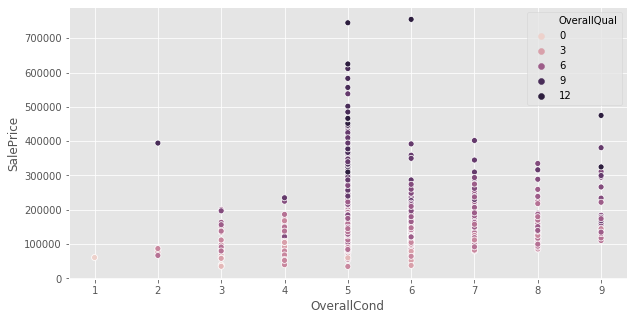

In [76]:
sns.scatterplot(data=xdata,x=xdata['OverallCond'],y=Yt,hue=xdata['OverallQual'])

## Write Data to a CSV to be used for the Predictions

In [77]:
xdata_train=pd.concat([xdata,Yt],axis=1)
xdata_train.to_csv('model_data.csv',index=False)

In [78]:
xdata.shape

(1459, 201)